In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from scipy.optimize import curve_fit
from ROOT import TVector3
import perform_calibrations as pc #import perform calibration package to get data
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import ROOT
import array
from matplotlib import rc
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
rc('text', usetex=True)

Welcome to JupyROOT 6.18/04


### Call calibration class

In [2]:
t = pc.tpc_calibration()

### Load data (takes 5-10 mins to run)
Compare corrected and uncorrected recoils

In [3]:
uncorrected_recoils = t.calibrate_recoils(corrected_energy = True, corrected_length = 0)
corrected_recoils = t.calibrate_recoils(corrected_energy = True, corrected_length = 0)
#ekey = 'full_corrected_energy'
#alphas = t.load_alphas()
#corrected_recoils = alphas
#ekey = 'track_energy'

/Users/vahsengrouplaptop/workspace/jeff_workspace/calibration/perform_calibrations.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['full_corrected_energy'][index] = dataframe['saturation_corrected_energy'][index] #truncate full correction range


### To validate corrected lengths (skip to next header unless validating)

In [4]:
def add_track_coordinates(df, i):
    x = df['x'].iloc[i]
    y = df['y'].iloc[i]
    z = df['z'].iloc[i]
    data = np.concatenate((x[:, np.newaxis], y[:, np.newaxis], z[:, np.newaxis]), axis=1)
    datamean = data.mean(axis = 0)
    uu, dd, vv = np.linalg.svd(data-datamean)
    xhat = TVector3(vv[0][0],vv[0][1],vv[0][2])
    zhat = TVector3(0,0,1)
    yhat = zhat.Cross(xhat).Unit()
    zhat_track = xhat.Cross(yhat).Unit()
    zhat = np.array([zhat.x(), zhat.y(), zhat.z()])
    yhat = np.array([yhat.x(), yhat.y(), yhat.z()])
    x_rel = x-x.mean()
    y_rel = y-y.mean()
    z_rel = z-z.mean()
    x_track = np.dot([[x_rel[i],y_rel[i],z_rel[i]] for i in range(0,len(x))],[vv[0][0],vv[0][1],vv[0][2]])
    y_track = np.dot([[x_rel[i],y_rel[i],z_rel[i]] for i in range(0,len(y))],yhat)
    z_track = np.dot([[x_rel[i],y_rel[i],z_rel[i]] for i in range(0,len(z))],zhat)
    
        #y_track = np.array([TVector3(x_rel[i],y_rel[i],z_rel[i])*yhat for i in range(0,len(y))])
    #data = np.concatenate((x_track[:, np.newaxis], y_track[:, np.newaxis], z[:, np.newaxis]), axis=1)
    length = (x_track.max() - x_track.min())
    width = (y_track.max() - y_track.min())
    return x_track, y_track, z_track

tpcs = corrected_recoils.keys()

for tpc in tpcs:
    xtrack = []
    ytrack = []
    ztrack = []
    corrected_recoils[tpc] = corrected_recoils[tpc].loc[corrected_recoils[tpc][ekey]>20]
    corrected_recoils[tpc].index = [i for i in range(0,len(corrected_recoils[tpc]))]
    for i in range(0,len(corrected_recoils[tpc])):
        xt, yt, zt = add_track_coordinates(corrected_recoils[tpc], i)
        xtrack.append(xt)
        ytrack.append(yt)
        ztrack.append(zt)
    corrected_recoils[tpc]['x_track'] = xtrack
    corrected_recoils[tpc]['y_track'] = ytrack
    corrected_recoils[tpc]['z_track'] = ztrack

NameError: name 'ekey' is not defined

In [ ]:
test = corrected_recoils['iiwi'].loc[corrected_recoils['iiwi']['track_energy']>500].iloc[0]
plt.scatter(test['x'], test['y_track'], c=test['tot'], cmap = 'viridis', vmin = 0, vmax = 13)
plt.colorbar()
plt.clf()
#sort(pd.DataFrame(test['x'])[0].unique())
df = pd.DataFrame()
df['x'] = test['x']
df['y_track'] = test['y_track']
df['Q'] = test['pixel_charge']*np.cos(test['theta']*180/np.pi)
df['tot'] = test['tot']
df['z_track'] = test['z_track']
df['z'] = test['z']
plt.hist2d(df['y_track'],df['Q'], bins = (40,56), range = ((-1000,1000),(0,60000)))
plt.colorbar()
df['tot'].min()
#for i in [df['x'].unique()[4]]:
#    plt.plot(df.loc[df['x']==i]['y_track'],df.loc[df['x']==i]['z_track'],'o')
df['Q'].max()

In [ ]:
y = array.array('d', df['y_track'])
q = array.array('d', df['Q'])
h = ROOT.TH2D("h", "", 40, -1000, 1000, 56, 0, 60000)
for i in range(0,len(y)):
    h.Fill(y[i],q[i])
f = ROOT.TF1("f1", "[0]*exp(-x^2/(2*[1])^2)", -1000, 1000)
#f.SetParameters(h.GetMaximum(), h.GetRMS())
max = df['Q'].max()
f.SetParLimits(0,28000,50000)
f.SetParLimits(1, 200, 300)
h.Fit(f, "B")
c = ROOT.TCanvas("myCanvasName","The Canvas Title",600,400)
h.GetYaxis().SetTitle('Q')
h.GetXaxis().SetTitle('y_track')
h.Draw('COLZ')
c.Draw()
f.GetParameters()[0]

In [ ]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as m3d
def plot(df, i):
    x = df.loc[df['track_energy'] > 20]['x'].iloc[i]
    y = df.loc[df['track_energy'] > 20]['y'].iloc[i]
    z = df.loc[df['track_energy'] > 20]['z'].iloc[i]
    c = df.loc[df['track_energy'] > 20]['tot'].iloc[i]
    data = np.concatenate((x[:, np.newaxis], y[:, np.newaxis], z[:, np.newaxis]), axis=1)
    datamean = data.mean(axis = 0)
    uu, dd, vv = np.linalg.svd(data-datamean)
    xhat = TVector3(vv[0][0],vv[0][1],vv[0][2])
    zhat = TVector3(0,0,1)
    yhat = zhat.Cross(xhat).Unit()
    yhat = np.array([yhat.x(), yhat.y(), yhat.z()])
    x_rel = x-x.mean()
    y_rel = y-y.mean()
    z_rel = z-z.mean()
    x_track = np.dot([[x_rel[i],y_rel[i],z_rel[i]] for i in range(0,len(x))],[vv[0][0],vv[0][1],vv[0][2]])
    y_track = np.dot([[x_rel[i],y_rel[i],z_rel[i]] for i in range(0,len(y))],yhat)
        #y_track = np.array([TVector3(x_rel[i],y_rel[i],z_rel[i])*yhat for i in range(0,len(y))])
    #data = np.concatenate((x_track[:, np.newaxis], y_track[:, np.newaxis], z[:, np.newaxis]), axis=1)
    length = (x_track.max() - x_track.min())
    width = (y_track.max() - y_track.min())
    width2 = 1/np.sqrt(len(y_track))*np.sqrt(np.sum(y_track**2))
    #if width > length:
    #    clength = width
    #else:
    #    clength = np.abs(length-0.5*width)
    clength = np.abs(length-width)
    clength2 = np.abs(length-width2)
    linepts = vv[0] * np.mgrid[-length/2:length/2:2j][:, np.newaxis]
    widthpts = yhat * np.mgrid[-width/2:width/2:2j][:, np.newaxis]
    clinepts = vv[0] * np.mgrid[-clength/2:clength/2:2j][:, np.newaxis]
    clinepts2 = vv[0] * np.mgrid[clength2/2:-clength2/2:2j][:, np.newaxis]
    linepts += datamean
    widthpts += datamean
    clinepts += datamean
    clinepts2 += datamean
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    p = ax.scatter3D(*data.T, c=c, cmap = 'viridis')
    ax.plot3D(*linepts.T, color = 'red', label = 'length')
    ax.plot3D(*widthpts.T, color = 'blue', label = 'width')
    ax.plot3D(*clinepts.T, color = 'magenta', label = 'corrected_length', linewidth=8)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    #ax.set_xlim(0,20000)
    #ax.set_ylim(0,18000)
    fig.colorbar(p, ax=ax, label = 'ToT')
    ax.legend()
    ax1 = fig.add_subplot(1, 2, 2, projection='3d')
    p = ax1.scatter3D(*data.T, c=c, cmap = 'viridis')
    ax1.plot3D(*linepts.T, color = 'red', label = 'length')
    ax1.plot3D(*widthpts.T, color = 'blue', label = 'width')
    ax1.plot3D(*clinepts2.T, color = 'magenta', label = 'corrected_length', linewidth=8)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('z')
    #ax1.set_xlim(0,20000)
    #ax1.set_ylim(0,18000)
    fig.colorbar(p, ax=ax1, label = 'ToT')
    ax.legend()
    fig.tight_layout()
    #print(length, clength, clength2)
    plt.show()
    print(df['theta'].iloc[i])
for i in range(0,20):
    plot(corrected_recoils['tako'], i)

### Visualize EvL for 4 TPCs with clean bands

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


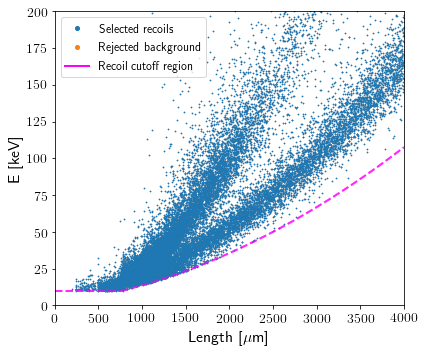

In [9]:
fig = plt.figure(figsize = (6,5))
for tpc in ['tako']:
    plt.rc('xtick', labelsize=14)
    plt.rc('ytick', labelsize=14)
    plt.rc('axes', labelsize=16)
    plt.rc('axes', titlesize=16)
    x_plt = np.linspace(0,20000,20001)
    x_plt1 = np.linspace(0,760,751)
    x_plt2 = np.linspace(760,20000,19251)
    x = np.array([1700, 2500, 10000])
    ymin = np.array([28, 50, 550])
    ymax = np.array([50, 95, 900])
    cut_min2 = np.polyfit(x,ymin, 2)
    cut_max2 = np.polyfit(x, ymax, 2)
    #plt.subplot(2,1,1)
    index = corrected_recoils[tpc].loc[(corrected_recoils[tpc]['full_corrected_energy'] > (cut_min2[0]*corrected_recoils[tpc]['length']**2 + cut_min2[1]*corrected_recoils[tpc]['length']+cut_min2[2]))&(corrected_recoils[tpc]['full_corrected_energy'] > 10)].index.to_numpy()
    plt.plot(corrected_recoils[tpc]['length'], corrected_recoils[tpc]['full_corrected_energy'], 'o', markersize = 0.5, alpha = 0.1, label = 'background', color = 'tab:orange')
    plt.plot(corrected_recoils[tpc]['length'][index], corrected_recoils[tpc]['full_corrected_energy'][index], 'o', markersize = 0.5, label = 'selected recoils', color = 'tab:blue')
    plt.plot(x_plt1, [10 for i in x_plt1], '--', color = 'magenta', linewidth = 2, alpha = 0.6)
    plt.plot(x_plt2, cut_min2[0]*x_plt2**2+cut_min2[1]*x_plt2+cut_min2[2], '--', color = 'magenta', linewidth = 2, alpha = 0.6, label = 'Recoil cutoff region')
    custom_lines = [Line2D([0], [0], marker='o', color='tab:blue', label='Selected recoils', markersize=4, markerfacecolor='tab:blue', linewidth = 0),Line2D([0], [0], marker='o', color='tab:orange', label='Rejected background', markersize=4, markerfacecolor='tab:orange', linewidth = 0), Line2D([0], '--', color='magenta', label='Recoil cutoff region', linewidth = 2)]
    plt.legend(handles = custom_lines)
    #plt.title('All events')
    plt.ylim(0,1000)
    plt.xlim(0,10000)
    plt.xlabel(r'Length [$\mu$m]')
    plt.ylabel('E [keV]')
    plt.subplot(1,1,1)
    plt.plot(corrected_recoils[tpc]['length'], corrected_recoils[tpc]['full_corrected_energy'], 'o', markersize = 0.5, alpha = 0.1, label = 'background', color = 'tab:orange')
    plt.plot(corrected_recoils[tpc]['length'][index], corrected_recoils[tpc]['full_corrected_energy'][index], 'o', markersize = 0.5, label = 'Selected recoils', color = 'tab:blue')
    plt.plot(x_plt1, [10 for i in x_plt1], '--', color = 'magenta', linewidth = 2, alpha = 0.6)
    plt.plot(x_plt2, cut_min2[0]*x_plt2**2+cut_min2[1]*x_plt2+cut_min2[2], '--', color = 'magenta', linewidth = 2, alpha = 0.6, label = 'Recoil cutoff region')
    plt.legend(handles = custom_lines)
    #plt.title('Zoomed in')
    plt.ylim(0,200)
    plt.xlim(0,4000)
    plt.xlabel(r'Length [$\mu$m]')
    plt.ylabel('E [keV]')
    plt.tight_layout()
plt.savefig('EvL_cuts_zoom.png')
plt.show()

[1.62248996e-06 3.18554217e-03 5.89558233e+00]


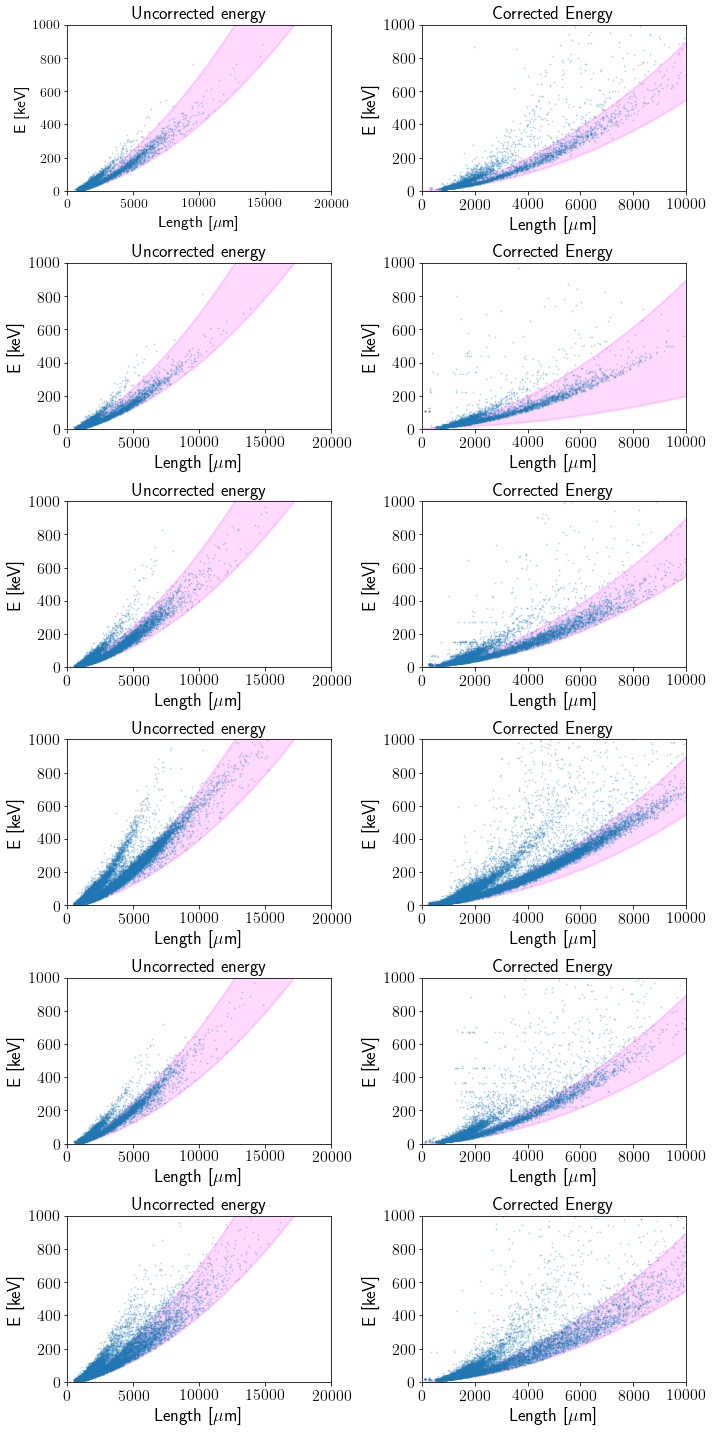

In [8]:
i = 1
fig = plt.figure(figsize = (10,20))
for tpc in ['iiwi', 'humu', 'nene', 'tako', 'palila', 'elepaio']:
    x_plt = np.linspace(0,20000,20001)
    plt.subplot(6,2,i)
    x = np.array([1700, 2500, 10000])
    ymin = np.array([18, 40, 400])
    ymax = np.array([40, 85, 700])
    cut_min = np.polyfit(x,ymin, 2)
    cut_max = np.polyfit(x, ymax, 2)
    plt.plot(uncorrected_recoils[tpc]['length'], uncorrected_recoils[tpc]['track_energy'], 'o', markersize = 1, alpha = 0.2, label = 'data')
    plt.fill_between(x_plt, cut_min[0]*x_plt**2+cut_min[1]*x_plt+cut_min[2], cut_max[0]*x_plt**2+cut_max[1]*x_plt+cut_max[2], color = 'magenta', linewidth = 2, alpha = 0.15, label = 'He recoil training region')
    plt.ylim(0,1000)
    plt.xlim(0,20000)
    plt.xlabel(r'Length [$\mu$m]')
    plt.ylabel('E [keV]')
    plt.rc('legend', fontsize=12)
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=18)
    plt.title('%s Uncorrected energy vs length'%(tpc.upper()))
    plt.title('Uncorrected energy')
    custom_lines = [Line2D([0], [0], marker='o', color='tab:blue', label='Data', markersize=4, markerfacecolor='tab:blue', linewidth = 0),
                    Patch(color='magenta', linewidth = 2,
                         label='He recoil training region', alpha = 0.3)]
    #plt.legend(handles = custom_lines)
    plt.subplot(6,2,i+1)
    if tpc == 'humu':
        ymin = np.array([16, 24, 200])
        print(np.polyfit(x,ymin, 2))
    else:
        ymin = np.array([28, 50, 550])
    ymax = np.array([50, 95, 900])
    cut_min2 = np.polyfit(x,ymin, 2)
    cut_max2 = np.polyfit(x, ymax, 2)
    plt.plot(corrected_recoils[tpc]['length'], corrected_recoils[tpc]['full_corrected_energy'], 'o', markersize = 1, alpha = 0.2, label = 'data')
    plt.fill_between(x_plt, cut_min2[0]*x_plt**2+cut_min2[1]*x_plt+cut_min2[2], cut_max2[0]*x_plt**2+cut_max2[1]*x_plt+cut_max2[2], color = 'magenta', linewidth = 2, alpha = 0.15, label = 'He recoil training region')
    plt.ylim(0,1000)
    plt.xlim(0,10000)
    plt.title('%s Corrected energy vs length'%(tpc.upper()))
    plt.title('Corrected Energy')
    plt.xlabel(r'Length [$\mu$m]')
    plt.ylabel('E [keV]')
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=18)
    #custom_lines = [Line2D([0], [0], marker='o', color='tab:blue', label='Data', markersize=4, markerfacecolor='tab:blue', linewidth = 0),Patch(color='magenta', linewidth = 2,label='He recoil training region', alpha = 0.3)]
    #plt.legend(handles = custom_lines)
    plt.tight_layout()
    i+=2
#plt.savefig('EvL_cuts_zoom.png')
plt.show()

### Apply He recoil band preliminary cuts (to train double gaussian fitter)

In [7]:
def apply_He_band_cuts(df, ecor = 'corrected'): #Cuts to train double Gaussian fit
    if ecor != 'corrected':
        #cut_min = np.array([ 5.51204819e-06, -6.90060241e-03,  1.78012048e+01])
        #cut_max = np.array([ 4.70883534e-06,  3.64728916e-02, -3.56124498e+01])
        cut_min = np.array([ 2.46987952e-06,  1.71265060e-02, -1.82530120e+01])
        cut_max = np.array([ 3.10240964e-06,  4.32198795e-02, -4.24397590e+01])
        ekey = 'track_energy'
        df = df.loc[df[ekey]>8]
    else:
        #cut_min = np.array([ 4.26706827e-06,  1.33283133e-02, -9.98995984e+00])
        #cut_max = np.array([ 5.38152610e-06,  2.73975904e-02, -1.21285141e+01])
        cut_min = np.array([4.71887550e-06, 7.68072289e-03, 1.30522088e+00])
        cut_max = np.array([ 6.15461847e-06,  3.04006024e-02, -1.94678715e+01])
        ekey = 'full_corrected_energy'
        df = df.loc[df[ekey]>10]
    df_red = df.loc[(df[ekey] > (cut_min[0]*df['length']**2 + cut_min[1]*df['length']+cut_min[2]))
                        & (df[ekey]<(cut_max[0]*df['length']**2  +cut_max[1]*df['length']+cut_max[2]))]
    df = df.loc[df[ekey] > (cut_min[0]*df['length']**2 + cut_min[1]*df['length']+cut_min[2])]
    return df, df_red

uncorrected_red = {}
corrected_red = {}
tpcs = corrected_recoils.keys()
for tpc in tpcs:
    uncorrected_recoils[tpc], uncorrected_red[tpc] = apply_He_band_cuts(corrected_recoils[tpc], ecor = 'uncorrected')
    corrected_recoils[tpc], corrected_red[tpc] = apply_He_band_cuts(corrected_recoils[tpc], ecor = 'corrected')

### Updated paper plots

[1.62248996e-06 3.18554217e-03 5.89558233e+00]


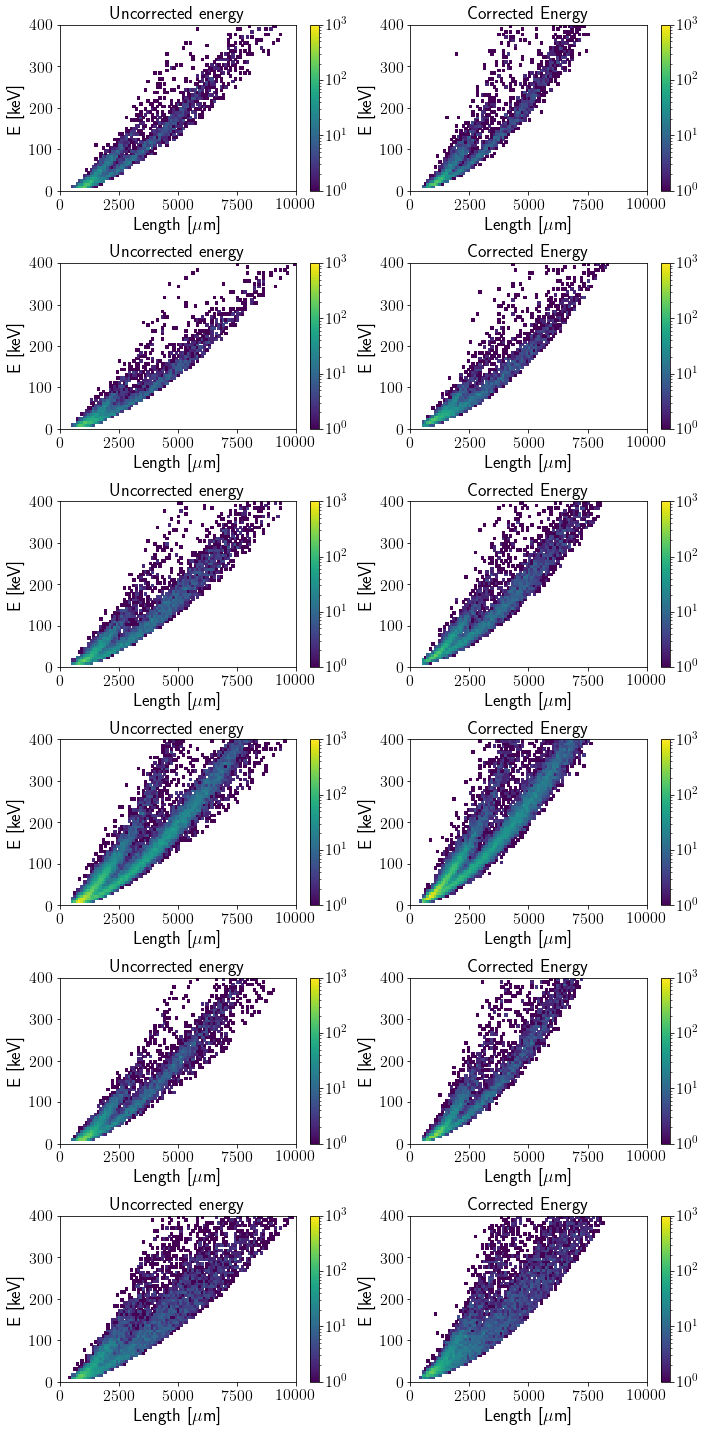

In [29]:
import matplotlib
i = 1
fig = plt.figure(figsize = (10,20))
cmap = plt.cm.viridis
cmap.set_under(color='white')
#vmin = 0.1
xm = 10000
ym = 400
nbinsx = 100
nbinsy = 60
h = {}
image = {}
for tpc in ['iiwi', 'humu', 'nene', 'tako', 'palila', 'elepaio']:
    x_plt = np.linspace(0,20000,20001)
    plt.subplot(6,2,i)
    x = np.array([1700, 2500, 10000])
    ymin = np.array([18, 40, 400])
    ymax = np.array([40, 85, 700])
    cut_min = np.polyfit(x,ymin, 2)
    cut_max = np.polyfit(x, ymax, 2)
    h[tpc+'_uncor'], xedges, yedges, image[tpc+'_uncor'] = plt.hist2d(uncorrected_recoils[tpc]['length'], uncorrected_recoils[tpc]['track_energy'], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=1000))
    #plt.fill_between(x_plt, cut_min[0]*x_plt**2+cut_min[1]*x_plt+cut_min[2], cut_max[0]*x_plt**2+cut_max[1]*x_plt+cut_max[2], color = 'magenta', linewidth = 2, alpha = 0.15, label = 'He recoil training region')
    plt.ylim(0,ym)
    plt.xlim(0,xm)
    plt.xlabel(r'Length [$\mu$m]')
    plt.ylabel('E [keV]')
    plt.rc('legend', fontsize=12)
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=18)
    plt.title('%s Uncorrected energy vs length'%(tpc.upper()))
    plt.title('Uncorrected energy')
    custom_lines = [Line2D([0], [0], marker='o', color='tab:blue', label='Data', markersize=4, markerfacecolor='tab:blue', linewidth = 0),
                    Patch(color='magenta', linewidth = 2,
                         label='He recoil training region', alpha = 0.3)]
    #plt.legend(handles = custom_lines)
    plt.colorbar()
    plt.subplot(6,2,i+1)
    if tpc == 'humu':
        ymin = np.array([16, 24, 200])
        print(np.polyfit(x,ymin, 2))
    else:
        ymin = np.array([28, 50, 550])
    ymax = np.array([50, 95, 900])
    cut_min2 = np.polyfit(x,ymin, 2)
    cut_max2 = np.polyfit(x, ymax, 2)
    h[tpc+'_cor'], xedges, yedges, image[tpc+'_cor'] = plt.hist2d(corrected_recoils[tpc]['length'], corrected_recoils[tpc]['full_corrected_energy'], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=1000))
    #plt.fill_between(x_plt, cut_min2[0]*x_plt**2+cut_min2[1]*x_plt+cut_min2[2], cut_max2[0]*x_plt**2+cut_max2[1]*x_plt+cut_max2[2], color = 'magenta', linewidth = 2, alpha = 0.15, label = 'He recoil training region')
    plt.ylim(0,ym)
    plt.xlim(0,xm)
    plt.title('%s Corrected energy vs length'%(tpc.upper()))
    plt.title('Corrected Energy')
    plt.xlabel(r'Length [$\mu$m]')
    plt.ylabel('E [keV]')
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=18)
    #custom_lines = [Line2D([0], [0], marker='o', color='tab:blue', label='Data', markersize=4, markerfacecolor='tab:blue', linewidth = 0),Patch(color='magenta', linewidth = 2,label='He recoil training region', alpha = 0.3)]
    #plt.legend(handles = custom_lines)
    plt.colorbar()
    plt.tight_layout()
    i+=2
#plt.savefig('EvL_cuts_zoom.png')
plt.show()

In [38]:
def gauss(x,mu,sigma,A): # for gaussian fit
    return A*exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2): #Sum of gaussians for bimodal fit
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

x_plt = np.linspace(0,500,501)
bins = 0.5*(yedges[1:]+yedges[:-1])

for tpc in ['iiwi', 'nene', 'tako', 'palila']:
    for loc in range(18,40):
        ekey = 'track_energy'

        index_He = uncorrected_red[tpc].loc[(uncorrected_red[tpc]['length'] < (xedges[loc+1])) & (uncorrected_red[tpc]['length'] > (xedges[loc]))].index.to_numpy()
        index_CO = uncorrected_recoils[tpc].loc[uncorrected_recoils[tpc].index.isin(index_He) == False].index.to_numpy()
        fig, ax = plt.subplots(2,2, figsize = (8,7), gridspec_kw={'hspace': 0.1, 'wspace': 0, 'width_ratios': [3, 1]})
        ax[0,0].hist2d(uncorrected_recoils[tpc]['length'], uncorrected_recoils[tpc][ekey], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=None))
        plt.colorbar(image[tpc+'_uncor'], ax=[ax[0,1]]).set_label(r'Recoils per bin', rotation = 270, labelpad = 20)
        ax[0,0].set_xticklabels([])
        ax[0,0].yaxis.set_minor_locator(AutoMinorLocator())
        ax[0,0].xaxis.set_minor_locator(AutoMinorLocator())
        ax[0,0].set_xlim(0,xm)
        ax[0,0].fill_between(np.array([xedges[loc], xedges[loc+1]]), 0, ym, alpha = 0.5, color = 'tab:orange')
        ax[0,0].set_ylim(0,ym)
        ax[0,0].set_ylabel(r'Energy [keV]')
        ax[0,0].grid(which='both')
        par1 = uncorrected_red[tpc][ekey][index_He].mean()
        par2 = uncorrected_red[tpc][ekey][index_He].std()
        par3 = len(uncorrected_red[tpc][ekey][index_He])
        par4 = uncorrected_recoils[tpc][ekey][index_CO].mean()
        par5 = uncorrected_recoils[tpc][ekey][index_CO].std()
        par6 = len(uncorrected_recoils[tpc][ekey][index_CO])
        seed_params = [par1,par2,par3,par4,par5,par6]
        ax[0,1].barh(bins, h[tpc+'_uncor'][loc], height = ym/nbinsy)
        try:
            params , cov = curve_fit(bimodal, bins, h[tpc+'_uncor'][loc], seed_params)
            ax[0,1].plot(bimodal(x_plt,*params),x_plt,color='red',lw=2,label='fit')
        except RuntimeError:
            pass
        ax[0,1].set_ylim(0,ym)
        ax[0,1].set_yticks([])
        ax[0,1].set_xticks([])

        ekey = 'full_corrected_energy'
        index_He = corrected_red[tpc].loc[(corrected_red[tpc]['length'] < (xedges[loc+1])) & (corrected_red[tpc]['length'] > (xedges[loc]))].index.to_numpy()
        index_CO = corrected_recoils[tpc].loc[corrected_recoils[tpc].index.isin(index_He) == False].index.to_numpy()
        ax[1,0].hist2d(corrected_recoils[tpc]['length'], corrected_recoils[tpc][ekey], bins = (nbinsx,nbinsy), range = ((0,xm),(0,ym)), norm = matplotlib.colors.LogNorm(vmin=1, vmax=None))
        plt.colorbar(image[tpc+'_cor'], ax=[ax[1,1]]).set_label(r'Recoils per bin', rotation = 270, labelpad = 20)
        ax[1,0].set_xticks([0,2000,4000,6000,8000])
        ax[1,0].yaxis.set_minor_locator(AutoMinorLocator())
        ax[1,0].xaxis.set_minor_locator(AutoMinorLocator())
        ax[1,0].set_xlim(0,xm)
        ax[1,0].fill_between(np.array([xedges[loc], xedges[loc+1]]), 0, ym, alpha = 0.5, color = 'tab:orange')
        ax[1,0].set_ylim(0,ym)
        ax[1,0].set_xlabel(r'Length [$\mu$m]')
        ax[1,0].set_ylabel(r'Energy [keV]')
        ax[1,0].grid(which='both')
        par1 = corrected_red[tpc][ekey][index_He].mean()
        par2 = corrected_red[tpc][ekey][index_He].std()
        par3 = len(corrected_red[tpc][ekey][index_He])
        par4 = corrected_recoils[tpc][ekey][index_CO].mean()
        par5 = corrected_recoils[tpc][ekey][index_CO].std()
        par6 = len(corrected_recoils[tpc][ekey][index_CO])
        seed_params = [par1,par2,par3,par4,par5,par6]
        try:
            params , cov = curve_fit(bimodal, bins, h[tpc+'_cor'][loc], seed_params)
            ax[1,1].plot(bimodal(x_plt,*params),x_plt,color='red',lw=2)
        except RuntimeError:
            pass
        ax[1,1].barh(bins, h[tpc+'_cor'][loc], height = ym/nbinsy)
        ax[1,1].set_ylim(0,ym)
        ax[1,1].set_yticks([])
        ax[1,1].set_xticks([])
        plt.savefig('%s_hist_%s.png'%(tpc, loc))
        plt.clf()

/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcPara

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control 

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

### Plot histograms for paper

In [ ]:
def get_hist_params(tpc, tpc_red, slice, width, bins, ecor = True, lcor = 0):
    if ecor != True:
        ekey = 'track_energy'     
    else:
        ekey = 'full_corrected_energy'
    if lcor == 0:
        lkey = 'length'
    elif lcor == 1:
        lkey = 'max_corrected_length'
    else:
        lkey = 'rms_corrected_length'
    index = tpc.loc[(tpc[lkey] < (slice + width)) & (tpc[lkey] > (slice - width))].index.to_numpy()
    index_red = tpc_red.loc[(tpc_red[lkey] < (slice + width)) & (tpc_red[lkey] > (slice - width))].index.to_numpy()
    def gauss(x,mu,sigma,A): # for gaussian fit
        return A*exp(-(x-mu)**2/2/sigma**2)
    data = tpc_red[ekey][index_red] #only He recoils
    full_data = tpc[ekey][index] #all recoils
    x_plt = np.linspace(0,400,401)
    def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2): #Sum of gaussians for bimodal fit
        return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)
    fig = plt.figure()
    y_full,x_full,_=plt.hist(full_data,bins,alpha=.3,color = 'tab:orange', label='All recoils', range = (0,400), orientation=u'horizontal')
    plt.close(fig)
    x_full=(x_full[1:]+x_full[:-1])/2
    CO = full_data.loc[full_data.index.isin(index_red) == False]
    expected_full=(np.mean(data),np.std(data),len(data), np.mean(CO), np.std(CO), len(full_data)-len(data))
    try:
        params_full,cov_full=curve_fit(bimodal,x_full,y_full, expected_full)
    except RuntimeError:
        pass
    return x_plt, full_data, params_full

def get_EvL_params(tpc, tpc_red, slice, width, bins, ecor = True, lcor = 0):
    if ecor != True:
        ekey = 'track_energy'     
    else:
        ekey = 'full_corrected_energy'
    if lcor == 0:
        lkey = 'length'
    elif lcor == 1:
        lkey = 'max_corrected_length'
    else:
        lkey = 'rms_corrected_length'
    index = tpc.loc[(tpc[lkey] < (slice + width)) & (tpc[lkey] > (slice - width))].index.to_numpy()
    index_red = tpc_red.loc[(tpc_red[lkey] < (slice + width)) & (tpc_red[lkey] > (slice - width))].index.to_numpy()
    return tpc[lkey], tpc[ekey], tpc[lkey][index], tpc[ekey][index]

for tpc in ['tako']:
    def gauss(x,mu,sigma,A): # for gaussian fit
        return A*exp(-(x-mu)**2/2/sigma**2)
    def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2): #Sum of gaussians for bimodal fit
        return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)
    fig, ax = plt.subplots(2,2, figsize = (8,6), gridspec_kw={'hspace': 0.5, 'wspace': 0, 'width_ratios': [3, 1]})
    l, e, rl, re = get_EvL_params(uncorrected_recoils['tako'], uncorrected_red['tako'], 2000, 25, 60, ecor = False, lcor = 0)
    ax[0,0].plot(l,e,'o', markersize = 0.5, alpha = 0.5)
    ax[0,0].plot(rl,re,'o', markersize = 0.5)
    ax[0,0].set_xlim(0,4000)
    ax[0,0].set_ylim(0,250)
    ax[0,0].set_xlabel(r'Length [$\mu$m]')
    ax[0,0].set_ylabel('Energy [keV]')
    ax[0,0].set_title("Uncorrected Energy")
    custom_points = [Line2D([0], [0], marker='o', color='tab:orange', label='Histogrammed recoils', markersize=4, markerfacecolor='tab:orange', linewidth = 0),
                    Line2D([0], [0], marker='o', color='tab:blue', label='Remaining recoils', markersize=4, markerfacecolor='tab:blue', linewidth = 0)]
    ax[0,0].legend(handles = custom_points)
    x_plt, full_data, params_full = get_hist_params(uncorrected_recoils['tako'], uncorrected_red['tako'], 2000, 25, 60, ecor = False, lcor = 0)
    ax[0,1].hist(full_data,bins = 60,alpha=.3,color = 'tab:orange', label='All recoils', range = (0,400), orientation=u'horizontal')
    ax[0,1].plot(bimodal(x_plt,*params_full),x_plt,color='red',lw=3,label='fit')
    ax[0,1].set_xlim(0,50)
    ax[0,1].set_ylim(0,250)
    ax[0,1].set_xticks([])
    ax[0,1].set_yticks([])
    l1, e1, rl1, re1 = get_EvL_params(uncorrected_recoils['tako'], uncorrected_red['tako'], 2000, 25, 60, ecor = False, lcor = 0)
    ax[1,0].plot(l,e,'o', markersize = 0.5, alpha = 0.5)
    ax[1,0].plot(rl,re,'o', markersize = 0.5)
    ax[1,0].set_xlim(0,4000)
    ax[1,0].set_ylim(0,250)
    ax[1,0].set_xlabel(r'Length [$\mu$m]')
    ax[1,0].set_ylabel('Energy [keV]')
    ax[1,0].set_title("Corrected Energy")
    ax[1,0].legend(handles = custom_points)
    x_plt1, full_data1, params_full1 = get_hist_params(uncorrected_recoils['tako'], uncorrected_red['tako'], 2000, 25, 60, ecor = False, lcor = 0)
    ax[1,1].hist(full_data,bins = 60,alpha=.3,color = 'tab:orange', label='All recoils', range = (0,400), orientation=u'horizontal')
    ax[1,1].plot(bimodal(x_plt,*params_full),x_plt,color='red',lw=3,label='fit')
    ax[1,1].set_xlim(0,50)
    ax[1,1].set_ylim(0,250)
    ax[1,1].set_xticks([])
    ax[1,1].set_yticks([])
    plt.savefig('profile_fits.png')
    fig.show()

### Plot histograms for validation

In [ ]:
def plot_histogram(tpc, tpc_red, slice, width, bins, ecor = True, lcor = 0):
    if ecor != True:
        ekey = 'track_energy'     
    else:
        ekey = 'full_corrected_energy'
    if lcor == 0:
        lkey = 'length'
    elif lcor == 1:
        lkey = 'max_corrected_length'
    else:
        lkey = 'rms_corrected_length'
    index = tpc.loc[(tpc[lkey] < (slice + width)) & (tpc[lkey] > (slice - width))].index.to_numpy()
    index_red = tpc_red.loc[(tpc_red[lkey] < (slice + width)) & (tpc_red[lkey] > (slice - width))].index.to_numpy()
    def gauss(x,mu,sigma,A): # for gaussian fit
        return A*exp(-(x-mu)**2/2/sigma**2)
    data = tpc_red[ekey][index_red] #only He recoils
    full_data = tpc[ekey][index] #all recoils
    #plt.subplot(3,1,1)
    #y,x,_=plt.hist(data,bins,alpha=.3,label='He_recoils only', range = (0,250))
    #x=(x[1:]+x[:-1])/2
    #expected=(np.mean(data),np.std(data),len(data)) #in the form of mu, sigma, A
    #params,cov=curve_fit(gauss,x,y, expected)
    #sigma=sqrt(diag(cov))
    x_plt = np.linspace(0,600,601)
    #plt.plot(x_plt,gauss(x_plt,*params),color='red',lw=3,label='fit')
    def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2): #Sum of gaussians for bimodal fit
        return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)
    #plt.legend()
    #plt.xlabel('Recoil Energy [keV]')
    plt.subplot(2,1,1)
    y_full,x_full,_=plt.hist(full_data,bins,alpha=.3,color = 'tab:orange', label='All recoils', range = (0,600))
    x_full=(x_full[1:]+x_full[:-1])/2
    CO = full_data.loc[full_data.index.isin(index_red) == False]
    expected_full=(np.mean(data),np.std(data),len(data), np.mean(CO), np.std(CO), len(full_data)-len(data))
    try:
        params_full,cov_full=curve_fit(bimodal,x_full,y_full, expected_full)
        plt.plot(x_plt,bimodal(x_plt,*params_full),color='red',lw=1,label='fit')
        plt.legend()
        plt.xlabel('Recoil Energy [keV]')
        sigma_full=sqrt(diag(cov_full))
        plt.title(r'Recoil Energy: %s $\leq$ length $<$ %s' %(int(slice - width), int(slice+width)))
        plt.subplot(2,1,2)
        plt.plot(tpc[lkey], tpc[ekey], 'o', markersize = 0.5, alpha = 0.5)
        plt.plot(tpc[lkey][index], tpc[ekey][index], 'o', markersize = 0.5)
        plt.ylim(0,600)
        plt.xlim(0,15000)
        plt.xlabel('Track Length [um]')
        plt.ylabel('Recoil Energy [keV]')
        plt.tight_layout()
        #print(params_full,'\n',sigma_full)
        He_reso = params_full[1]/params_full[0]
        He_reso_err = He_reso*np.sqrt((sigma_full[1]/params_full[1])**2+(sigma_full[0]/params_full[0])**2)
        CO_reso = params_full[4]/params_full[3]
        CO_reso_err = CO_reso*np.sqrt((sigma_full[4]/params_full[4])**2+(sigma_full[3]/params_full[3])**2)
        #print('He recoil resolution: %s +/- %s'%(He_reso, He_reso_err))
        #print('CO recoil resolution: %s +/- %s'%(CO_reso, CO_reso_err))
        length = tpc[lkey][index].mean()
        length_err = tpc[lkey][index].std()/np.sqrt(len(index))
        #print('length = %s +/- %s'%(length, length_err))
    except RuntimeError:
        pass

for tpc in ['iiwi', 'nene', 'tako', 'palila']:
    #he_slices = np.array([120*i+1750 for i in range(0,6)] + [200*i+2450 for i in range(0,6)])
    #he_width = [60 for i in range(0,6)] + [100 for i in range (0,6)]
    #bins = 150
    #he_slices = [50*i+1750 for i in range(0,6)] + [100*i+2100 for i in range(0,7)] + [200*i + 2850 for i in range(0,18)] 
    #he_widths = [25 for i in range(0,15)] + [50 for i in range(0,7)] + [100 for i in range(0,18)]
    #bins = 90
    #CO_slices = [50*i+1700 for i in range(0,30)]
    #CO_widths = [25 for i in range(0,30)]
    #bins = 135
    he_slices = [20*i+1200 for i in range(0,51)] + [40*i+2230 for i in range (0,51)] + [80*i+4290 for i in range (0,31)]
    he_widths = [10 for i in range(0,51)] + [20 for i in range (0,51)] + [40 for i in range (0,31)]
    bins = 101
    for i in range(0,len(he_slices)):
    #for i in range(0,len(CO_slices)):
        plot_histogram(uncorrected_recoils[tpc], uncorrected_red[tpc], he_slices[i], he_widths[i], bins, ecor = False, lcor = 0)
        plt.savefig('%s_uncor_%s_slice.png'%(tpc, he_slices[i]))
        #plot_histogram(uncorrected_recoils[tpc], uncorrected_red[tpc], CO_slices[i], CO_widths[i], bins, ecor = False, lcor = 0)
        #plt.savefig('%s_CO_uncor_%s_slice.png'%(tpc, CO_slices[i]))
        plt.clf()
        plot_histogram(corrected_recoils[tpc], corrected_red[tpc], he_slices[i], he_widths[i], bins, ecor = True, lcor = 0)
        plt.savefig('%s_cor_%s_slice.png'%(tpc, he_slices[i]))
        #plot_histogram(corrected_recoils[tpc], corrected_red[tpc], CO_slices[i], CO_widths[i], bins, ecor = True, lcor = 0)
        #plt.savefig('%s_CO_cor_%s_slice.png'%(tpc, CO_slices[i]))
        plt.clf()

#plot_histogram(corrected_recoils['iiwi'], corrected_red['iiwi'], 2000, 25, 60, ecor = True, lcor = 0)

### Extract energy resolutions

In [ ]:
def get_fit_parameters(tpc, tpc_red, slice, width, bins, ecor = True, lcor = 0):
    if ecor != True:
        ekey = 'track_energy'
    else:
        ekey = 'full_corrected_energy'
    if lcor == 0:
        lkey = 'length'
    elif lcor == 1:
        lkey = 'max_corrected_length'
    else:
        lkey = 'rms_corrected_length'
    index = tpc.loc[(tpc[lkey] < (slice + width)) & (tpc[lkey] > (slice - width))].index.to_numpy()
    index_red = tpc_red.loc[(tpc_red[lkey] < (slice + width)) & (tpc_red[lkey] > (slice - width))].index.to_numpy()
    def gauss(x,mu,sigma,A): # for gaussian fit
        return A*exp(-(x-mu)**2/2/sigma**2)
    data = tpc_red[ekey][index_red] #only He recoils
    full_data = tpc[ekey][index] #all recoils
    #y,x,_=plt.hist(data,bins,alpha=.3,label='He_recoils only', range = (0,2000))
    #x=(x[1:]+x[:-1])/2
    #expected=(np.mean(data),np.std(data),len(data)) #in the form of mu, sigma, A
    #params,cov=curve_fit(gauss,x,y, expected)
    #sigma=sqrt(diag(cov))
    def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2): #Sum of gaussians for bimodal fit
        return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)
    y_full,x_full,_=plt.hist(full_data,bins,alpha=.3,color = 'tab:orange', label='All recoils', range = (0,600))
    x_full=(x_full[1:]+x_full[:-1])/2
    CO = full_data.loc[full_data.index.isin(index_red) == False]
    expected_full=(np.mean(data),np.std(data),len(data), np.mean(CO), np.std(CO), len(full_data)-len(data))
    try:
        #if len(full_data < 40):
        #    He_reso = np.nan
        #    He_reso_err = np.nan
        params_full,cov_full=curve_fit(bimodal,x_full,y_full, expected_full)
        sigma_full=sqrt(diag(cov_full))
        E_He = params_full[0]
        dE_He = params_full[1]
        E_CO = params_full[3]
        dE_CO = params_full[4]
        He_reso = params_full[1]/params_full[0]
        He_reso_err = He_reso*np.sqrt((sigma_full[1]/params_full[1])**2+(sigma_full[0]/params_full[0])**2)
        CO_reso = params_full[4]/params_full[3]
        CO_reso_err = CO_reso*np.sqrt((sigma_full[4]/params_full[4])**2+(sigma_full[3]/params_full[3])**2)
        print('He recoil resolution: %s +/- %s'%(He_reso, He_reso_err))
        print('CO recoil resolution: %s +/- %s'%(CO_reso, CO_reso_err))
        length = tpc[lkey][index].mean()
        length_err = tpc[lkey][index].std()/np.sqrt(len(index))
        print('length = %s +/- %s'%(length, length_err))
        plt.clf()
    except RuntimeError:
        length, length_err, He_reso, He_reso_err, CO_reso, CO_reso_err, E_He, dE_He, E_CO, dE_CO = np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
        pass
    return length, length_err, He_reso, He_reso_err, CO_reso, CO_reso_err, E_He, dE_He, E_CO, dE_CO

def make_dataframes(df, df_red, slices = [2000, 2200, 2400, 2600, 2800, 3000, 3200, 3400], widths = [25, 25, 50, 50, 50, 50, 50, 50], bins = 60, ecor = True, lcor = 0):
    tpcs = ['iiwi', 'nene', 'tako', 'palila']
    l = {}
    dl = {}
    He_res = {}
    He_res_err = {}
    CO_res = {}
    CO_res_err = {}
    E_He = {}
    dE_He = {}
    E_CO = {}
    dE_CO = {}
    for tpc in tpcs:
        #slices = [80*i+1200 for i in range(0,26)] + [120*i+3300 for i in range (0,25)]
        #widths = [40 for i in range(0,26)] + [60 for i in range (0,25)]
        #bins = 60
        slices = [10*i+1200 for i in range(0,201)] + [20*i+3220 for i in range (0,200)]
        widths = [5 for i in range(0,201)] + [10 for i in range (0,200)]
        bins = 60
        l[tpc], dl[tpc], He_res[tpc], He_res_err[tpc], CO_res[tpc], CO_res_err[tpc], E_He[tpc], dE_He[tpc], E_CO[tpc], dE_CO[tpc] = [], [], [], [], [], [], [], [], [], []
        for i in range(0,len(slices)):
            length, length_err, He_reso, He_reso_err, CO_reso, CO_reso_err, En_He, dEn_He, En_CO, dEn_CO = get_fit_parameters(df[tpc], df_red[tpc], slices[i], widths[i], bins, ecor, lcor)
            if (np.abs(He_reso_err)) > He_reso or (He_reso_err == np.nan) or (He_reso < 0):
                He_reso = np.nan
                He_reso_err = np.nan
            '''
            if tpc == 'palila':
                if (length > 5150) and (length < 5350):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (length > 6150) and (length < 6350):
                    He_reso = np.nan
                    He_reso_err = np.nan
            if tpc == 'iiwi':
                if (length > 5150) and (length < 5350):
                    He_reso = np.nan
                    He_reso_err = np.nan
            if tpc == 'nene':
                if (length > 5650) and (length < 5850):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (length > 4150) and (length < 4350):
                    He_reso = np.nan
                    He_reso_err = np.nan
            if tpc == 'tako':
                if (length >= 5700):
                    He_reso = np.nan
                    He_reso_err = np.nan
            
            if tpc == 'palila':
                if (length > 4600) and (length < 4800):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (length >= 5020):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (length > 6550) and (length < 6600):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if length <=1810:
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (length > 1990) and (length < 2010):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (length > 2670) and (length < 2730):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (length > 1790) and (length < 1810):
                    CO_reso = np.nan
                    CO_reso_err = np.nan
                if (length > 2540) and (length < 2560):
                    CO_reso = np.nan
                    CO_reso_err = np.nan
                if (length >= 2690):
                    CO_reso = np.nan
                    CO_reso_err = np.nan
            if tpc == 'iiwi':
                if (length > 4200) and (length < 4300):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (length > 6000) and (length < 6100):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (length > 6200) and (length < 6300):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (length > 1940) and (length < 1960):
                    He_reso = np.nan
                    He_reso_err = np.nan
                    CO_reso = np.nan
                    CO_reso_err = np.nan
                if (length > 2470) and (length < 2530):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (length > 3420) and (length < 3480):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (length > 3020) and (length < 3080):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (length > 3820) and (length < 3880):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (length > 5400) and (length < 5500):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (length > 1690) and (length < 1710):
                    CO_reso = np.nan
                    CO_reso_err = np.nan
                if (length > 1840) and (length < 1860):
                    CO_reso = np.nan
                    CO_reso_err = np.nan
                if (length > 1890) and (length < 1910):
                    CO_reso = np.nan
                    CO_reso_err = np.nan
                if (length > 1990) and (length < 2010):
                    CO_reso = np.nan
                    CO_reso_err = np.nan
                if (length > 2340) and (length < 2360):
                    CO_reso = np.nan
                    CO_reso_err = np.nan
                if (length > 2490) and (length < 2510):
                    CO_reso = np.nan
                    CO_reso_err = np.nan
                if (length > 2590) and (length < 2610):
                    CO_reso = np.nan
                    CO_reso_err = np.nan
                if (length > 2710):
                    CO_reso = np.nan
                    CO_reso_err = np.nan
            if tpc == 'nene':
                if (length > 4000) and (length < 4100):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (length > 4550) and (length < 4600):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (length >= 5050):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (length > 2830) and (length < 2870):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (length > 1840) and (length < 1860):
                    CO_reso = np.nan
                    CO_reso_err = np.nan
                if (length > 2290) and (length < 2310):
                    CO_reso = np.nan
                    CO_reso_err = np.nan
                if (length > 2390) and (length < 2410):
                    CO_reso = np.nan
                    CO_reso_err = np.nan
                if (length > 2640) and (length < 2660):
                    CO_reso = np.nan
                    CO_reso_err = np.nan
                if (length > 2690) and (length < 2710):
                    CO_reso = np.nan
                    CO_reso_err = np.nan
                if (length >= 2790):
                    CO_reso = np.nan
                    CO_reso_err = np.nan
            if tpc == 'tako':
                if (length >= 6050):
                    He_reso = np.nan
                    He_reso_err = np.nan
                if (length > 2690) and (length < 2710):
                    CO_reso = np.nan
                    CO_reso_err = np.nan
                if (length > 2790) and (length < 2810):
                    CO_reso = np.nan
                    CO_reso_err = np.nan
                if (length > 3140) and (length < 3160):
                    CO_reso = np.nan
                    CO_reso_err = np.nan
            '''
            l[tpc].append(length)
            dl[tpc].append(length_err)
            He_res[tpc].append(He_reso)
            He_res_err[tpc].append(He_reso_err)
            CO_res[tpc].append(CO_reso)
            CO_res_err[tpc].append(CO_reso_err)
            E_He[tpc].append(En_He)
            dE_He[tpc].append(dEn_He)
            E_CO[tpc].append(En_CO)
            dE_CO[tpc].append(dEn_CO)
    l = pd.DataFrame.from_dict(l)
    dl = pd.DataFrame.from_dict(dl)
    He_res = pd.DataFrame.from_dict(He_res)
    He_res_err = pd.DataFrame.from_dict(He_res_err)
    CO_res = pd.DataFrame.from_dict(CO_res)
    CO_res_err = pd.DataFrame.from_dict(CO_res_err)
    E_He = pd.DataFrame.from_dict(E_He)
    dE_He = pd.DataFrame.from_dict(dE_He)
    E_CO = pd.DataFrame.from_dict(E_CO)
    dE_CO = pd.DataFrame.from_dict(dE_CO)
    '''
    for tpc in ['tako']:
        slices = [10*i+1200 for i in range(0,201)] + [20*i+3220 for i in range (0,200)]
        widths = [5 for i in range(0,201)] + [10 for i in range (0,200)]
        bins = 60
        l[tpc], dl[tpc], He_res[tpc], He_res_err[tpc], CO_res[tpc], CO_res_err[tpc], E_He[tpc], dE_He[tpc], E_CO[tpc], dE_CO[tpc] = [], [], [], [], [], [], [], [], [], []
        for i in range(0,len(slices)):
            length, length_err, He_reso, He_reso_err, CO_reso, CO_reso_err, En_He, dEn_He, En_CO, dEn_CO = get_fit_parameters(df[tpc], df_red[tpc], slices[i], widths[i], bins, ecor, lcor)
            if (np.abs(He_reso_err)) > He_reso or He_reso_err == np.nan:
                He_reso = np.nan
                He_reso_err = np.nan
            l[tpc].append(length)
            dl[tpc].append(length_err)
            He_res[tpc].append(He_reso)
            He_res_err[tpc].append(He_reso_err)
            CO_res[tpc].append(CO_reso)
            CO_res_err[tpc].append(CO_reso_err)
            E_He[tpc].append(En_He)
            dE_He[tpc].append(dEn_He)
            E_CO[tpc].append(En_CO)
            dE_CO[tpc].append(dEn_CO)
    l = pd.DataFrame.from_dict(l)
    dl = pd.DataFrame.from_dict(dl)
    He_res = pd.DataFrame.from_dict(He_res)
    He_res_err = pd.DataFrame.from_dict(He_res_err)
    CO_res = pd.DataFrame.from_dict(CO_res)
    CO_res_err = pd.DataFrame.from_dict(CO_res_err)
    E_He = pd.DataFrame.from_dict(E_He)
    dE_He = pd.DataFrame.from_dict(dE_He)
    E_CO = pd.DataFrame.from_dict(E_CO)
    dE_CO = pd.DataFrame.from_dict(dE_CO)
    '''
    return l, dl, He_res, He_res_err, CO_res, CO_res_err, E_He, dE_He, E_CO, dE_CO

#he_slices = np.array([120*i+1750 for i in range(0,6)] + [200*i+2450 for i in range(0,6)])
#he_widths = [60 for i in range(0,6)] + [100 for i in range (0,6)]
#he_slices = [400*i+2000 for i in range(0,4)]
#he_widths = [200 for i in range(0,4)]
#bins = 150
#he_slices = [50*i+1750 for i in range(0,6)] + [100*i+2100 for i in range(0,7)] + [200*i + 2850 for i in range(0,18)]
#he_widths = [25 for i in range(0,15)] + [50 for i in range(0,7)] + [100 for i in range(0,18)]
#bins = 90
#CO_slices = [50*i+1700 for i in range(0,15)]
#CO_widths = [25 for i in range(0,15)]
#bins = 90

#he_slices = [500*i+1750 for i in range(0,10)]
#he_widths = [250 for i in range(0,10)]
#bins = 60

#he_slices = [10*i+1200 for i in range(0,201)] + [20*i+3220 for i in range (0,200)]
#he_widths = [5 for i in range(0,201)] + [10 for i in range (0,200)]
#bins = 60

he_slices = [20*i+1200 for i in range(0,51)] + [40*i+2230 for i in range (0,51)] + [80*i+4290 for i in range (0,31)]
he_widths = [10 for i in range(0,51)] + [20 for i in range (0,51)] + [40 for i in range (0,31)]
bins = 101

case1_l, case1_l_err, case1_He_res, case1_He_res_err, case1_CO_res, case1_CO_res_err, case1_E_He, case1_E_He_err, case1_E_CO, case1_E_CO_err = make_dataframes(uncorrected_recoils, uncorrected_red, slices = he_slices, widths = he_widths, bins = bins, ecor = False, lcor = 0)
case2_l, case2_l_err, case2_He_res, case2_He_res_err, case2_CO_res, case2_CO_res_err, case2_E_He, case2_E_He_err, case2_E_CO, case2_E_CO_err = make_dataframes(corrected_recoils, corrected_red, slices = he_slices, widths = he_widths, bins = bins, ecor = True, lcor = 0)
#case1_l, case1_l_err, case1_He_res, case1_He_res_err, case1_CO_res, case1_CO_res_err = make_dataframes(uncorrected_recoils, uncorrected_red, slices = CO_slices, widths = CO_widths, bins = bins, ecor = False, lcor = 0)
#case2_l, case2_l_err, case2_He_res, case2_He_res_err, case2_CO_res, case2_CO_res_err = make_dataframes(corrected_recoils, corrected_red, slices = CO_slices, widths = CO_widths, bins = bins, ecor = True, lcor = 0)

### Plot He recoil resolutions vs energy

In [ ]:
fig = plt.figure(figsize = (8,8))
i = 0
tpcs = [val for val in case1_l.columns]
for tpc in tpcs:
    plt.subplot(2,2,i+1)
    plt.errorbar(case1_E_He[tpc], case1_He_res[tpc], case1_He_res_err[tpc], case1_E_He_err[tpc], 'o', markersize = 0.5, label = 'Uncorrected Energy', color = 'red')
    plt.errorbar(case2_E_He[tpc], case2_He_res[tpc], case2_He_res_err[tpc], case2_E_He_err[tpc], 'o', markersize = 0.5, label = 'Corrected Energy', color = 'blue')
    plt.xlabel('Energy [keV]')
    plt.ylabel(r'$\sigma_E$/E')
    plt.title(tpc)
    plt.ylim(0,0.25)
    plt.xlim(0,400)
    i+=1
    plt.legend(loc = 'lower left')
fig.tight_layout()
#plt.savefig('energy_resolution_vs_E_highE.png')
plt.show()

### Plot He recoil resolutions vs L

In [ ]:
fig = plt.figure(figsize = (8,8))
i = 0
tpcs = [val for val in case1_l.columns]
for tpc in tpcs:
    plt.subplot(2,2,i+1)
    plt.errorbar(case1_l[tpc], case1_He_res[tpc], case1_He_res_err[tpc], case1_l_err[tpc], 'o', markersize = 0.5, label = 'Uncorrected Energy', color = 'red')
    plt.errorbar(case2_l[tpc], case2_He_res[tpc], case2_He_res_err[tpc], case2_l_err[tpc], 'o', markersize = 0.5, label = 'Corrected Energy', color = 'blue')
    plt.xlabel('Length [$\mu$m]')
    plt.ylabel(r'$\sigma_E$/E')
    plt.title(tpc)
    plt.ylim(0,0.2)
    plt.xlim(0,8000)
    i+=1
    plt.legend(loc = 'lower left')
fig.tight_layout()
#plt.savefig('energy_resolution_vs_l.png')
plt.show()

### Plot C/O recoil resolutions

In [ ]:
fig = plt.figure(figsize = (8,8))
i = 0
tpcs = [val for val in case1_l.columns]
for tpc in tpcs:
    plt.subplot(2,2,i+1)
    plt.errorbar(case1_E_CO[tpc], case1_CO_res[tpc], case1_CO_res_err[tpc], case1_E_CO_err[tpc], 'o', markersize = 0.5, label = 'Uncorrected Energy', color = 'red')
    plt.errorbar(case2_E_CO[tpc], case2_CO_res[tpc], case2_CO_res_err[tpc], case2_E_CO_err[tpc], 'o', markersize = 0.5, label = 'Corrected Energy', color = 'blue')
    plt.xlabel('Energy [keV]')
    plt.ylabel(r'$\sigma_E$/E')
    plt.title(tpc)
    plt.legend(loc = 'lower left')
    plt.ylim(0,0.4)
    plt.xlim(0,160)
    i+=1
fig.tight_layout()
plt.savefig('CO_energy_resolution_vs_E.png')
plt.show()

### Testing smaller partitions of energy resolutions

In [ ]:

palila = pd.DataFrame()
palila['uE'] = case1_E_He['palila']
palila['uE_err'] = case1_E_He_err['palila']
palila['ul'] = case1_l['palila']
palila['uHe'] = case1_He_res['palila']
palila['uHe_err'] = case1_He_res_err['palila']
palila['ul_err'] = case1_l_err['palila']
palila['cl'] = case2_l['palila']
palila['cHe'] = case2_He_res['palila']
palila['cHe_err'] = case2_He_res_err['palila']
palila['cl_err'] = case2_l_err['palila']
palila['cE'] = case2_E_He['palila']
palila['cE_err'] = case2_E_He_err['palila']

iiwi = pd.DataFrame()
iiwi['uE'] = case1_E_He['iiwi']
iiwi['uE_err'] = case1_E_He_err['iiwi']
iiwi['ul'] = case1_l['iiwi']
iiwi['uHe'] = case1_He_res['iiwi']
iiwi['uHe_err'] = case1_He_res_err['iiwi']
iiwi['ul_err'] = case1_l_err['iiwi']
iiwi['cl'] = case2_l['iiwi']
iiwi['cHe'] = case2_He_res['iiwi']
iiwi['cHe_err'] = case2_He_res_err['iiwi']
iiwi['cl_err'] = case2_l_err['iiwi']
iiwi['cE'] = case2_E_He['iiwi']
iiwi['cE_err'] = case2_E_He_err['iiwi']

tako = pd.DataFrame()
tako['uE'] = case1_E_He['tako']
tako['uE_err'] = case1_E_He_err['tako']
tako['ul'] = case1_l['tako']
tako['uHe'] = case1_He_res['tako']
tako['uHe_err'] = case1_He_res_err['tako']
tako['ul_err'] = case1_l_err['tako']
tako['cl'] = case2_l['tako']
tako['cHe'] = case2_He_res['tako']
tako['cHe_err'] = case2_He_res_err['tako']
tako['cl_err'] = case2_l_err['tako']
tako['cE'] = case2_E_He['tako']
tako['cE_err'] = case2_E_He_err['tako']

nene = pd.DataFrame()
nene['uE'] = case1_E_He['nene']
nene['uE_err'] = case1_E_He_err['nene']
nene['ul'] = case1_l['nene']
nene['uHe'] = case1_He_res['nene']
nene['uHe_err'] = case1_He_res_err['nene']
nene['ul_err'] = case1_l_err['nene']
nene['cl'] = case2_l['nene']
nene['cHe'] = case2_He_res['nene']
nene['cHe_err'] = case2_He_res_err['nene']
nene['cl_err'] = case2_l_err['nene']
nene['cE'] = case2_E_He['nene']
nene['cE_err'] = case2_E_He_err['nene']

results = {'iiwi': iiwi, 'nene': nene, 'tako': tako, 'palila': palila}

#results = {'tako': tako}

In [ ]:
fig = plt.figure(figsize = (8,8))
j = 1
n = 16
for tpc in results.keys():
    plt.subplot(2,2,j)
    for i in range(0,n):
        ulerr = np.sqrt((np.array_split(results[tpc].dropna(),n)[i]['ul_err']**2).sum())/np.sqrt(n)
        uheerr = np.sqrt((np.array_split(results[tpc].dropna(),n)[i]['uHe_err']**2).sum())/np.sqrt(n)
        clerr = np.sqrt((np.array_split(results[tpc].dropna(),n)[i]['cl_err']**2).sum())/np.sqrt(n)
        cheerr = np.sqrt((np.array_split(results[tpc].dropna(),n)[i]['cHe_err']**2).sum())/np.sqrt(n)
        plt.errorbar(np.array_split(results[tpc].dropna(),n)[i]['ul'].mean(), np.array_split(results[tpc].dropna(),n)[i]['uHe'].mean(), uheerr, ulerr, 'o', markersize = 4, label = 'Uncorrected Energy', color = 'red')
        plt.errorbar(np.array_split(results[tpc].dropna(),n)[i]['cl'].mean(), np.array_split(results[tpc].dropna(),n)[i]['cHe'].mean(), cheerr, clerr, 'o', markersize = 4, label = 'Corrected Energy', color = 'blue')
    plt.xlabel('Length [$\mu$m]')
    plt.ylabel(r'$\sigma_E$/E')
    plt.title(tpc)
    plt.ylim(0,0.25)
    plt.xlim(0,8000)
    j+=1
    #plt.legend(loc = 'lower left')
fig.tight_layout()
#plt.savefig('energy_resolution_vs_l.png')
plt.show()

In [ ]:
fig = plt.figure(figsize = (8,8))
j = 1
n = 16
for tpc in results.keys():
    plt.subplot(2,2,j)
    for i in range(0,n):
        #ulerr = np.sqrt((np.array_split(results[tpc].dropna(),n)[i]['uE_err']**2).sum())/np.sqrt(n)
        #uheerr = np.sqrt((np.array_split(results[tpc].dropna(),n)[i]['uHe_err']**2).sum())/np.sqrt(n)
        clerr = np.sqrt((np.array_split(results[tpc].dropna(),n)[i]['cE_err']**2).sum())/np.sqrt(n)
        cheerr = np.sqrt((np.array_split(results[tpc].dropna(),n)[i]['cHe_err']**2).sum())/np.sqrt(n)
        #plt.errorbar(np.array_split(results[tpc].dropna(),n)[i]['uE'].mean(), np.array_split(results[tpc].dropna(),n)[i]['uHe'].mean(), uheerr, ulerr, 'o', markersize = 4, label = 'Uncorrected Energy', color = 'red')
        plt.errorbar(np.array_split(results[tpc].dropna(),n)[i]['cE'].mean(), np.array_split(results[tpc].dropna(),n)[i]['cHe'].mean(), cheerr, clerr, 'o', markersize = 4, label = 'Corrected Energy', color = 'blue')
    plt.xlabel('E [keV]')
    plt.ylabel(r'$\sigma_E$/E')
    plt.title(tpc)
    plt.ylim(0,0.25)
    #plt.xlim(0,8000)
    j+=1
    #plt.legend(loc = 'lower left')
fig.tight_layout()
#plt.savefig('energy_resolution_vs_l.png')
plt.show()